# Dataset MNIST

Este notebook aplica nossa rede neural construída com JAX a um problema clássico de classificação de imagens. O modelo é treinado para reconhecer e classificar dígitos de 0 a 9 a partir de imagens em escala de cinza, servindo como um benchmark para avaliar o desempenho da nossa implementação em um dos datasets mais icônicos da área de Machine Learning.

Fonte do Dataset: [MNIST on Kaggle](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

## Importação de bibliotecas

- `jax.numpy` para operações vetorizadas com JAX.
- `matplotlib.pyplot` para visualizações.
- `pandas` para manipulação de dados.
- `train_test_split` para particionar dados.
- `ann` para funções de rede neural.

In [1]:
import os
import numpy as np
import jax.numpy as jnp
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import ann

SEMENTE_GLOBAL = 42

In [2]:
def ler_imagens_mnist(caminho_arquivo):
    """Lê imagens do formato de arquivo MNIST"""
    with open(caminho_arquivo, "rb") as f:
        _ = f.read(4)
        n_imagens = int.from_bytes(f.read(4), "big")
        n_linhas = int.from_bytes(f.read(4), "big")
        n_colunas = int.from_bytes(f.read(4), "big")
        buffer = f.read()
        dados = np.frombuffer(buffer, dtype=np.uint8)
        return dados.reshape(n_imagens, n_linhas * n_colunas)


def ler_rotulos_mnist(caminho_arquivo):
    """Lê rótulos do formato de arquivo MNIST"""
    with open(caminho_arquivo, "rb") as f:
        _ = f.read(4)  # Pula o 'magic number'
        _ = int.from_bytes(f.read(4), "big")
        buffer = f.read()
        dados = np.frombuffer(buffer, dtype=np.uint8)
        return dados


def carregar_mnist_local(caminho_pasta):
    """Carrega o dataset MNIST"""
    caminho_treino_img = os.path.join(caminho_pasta, "train-images.idx3-ubyte")
    caminho_treino_lbl = os.path.join(caminho_pasta, "train-labels.idx1-ubyte")
    caminho_teste_img = os.path.join(caminho_pasta, "t10k-images.idx3-ubyte")
    caminho_teste_lbl = os.path.join(caminho_pasta, "t10k-labels.idx1-ubyte")

    X_train = ler_imagens_mnist(caminho_treino_img)
    y_train = ler_rotulos_mnist(caminho_treino_lbl)
    X_test = ler_imagens_mnist(caminho_teste_img)
    y_test = ler_rotulos_mnist(caminho_teste_lbl)

    return (X_train, y_train), (X_test, y_test)

In [3]:
caminho_dados_mnist = '../datasets/mnist_data/' # Ajuste se necessário

(X_train_flat, y_train_int), (X_test_int, y_test_int) = carregar_mnist_local(
    caminho_dados_mnist
)
print("Dados MNIST locais carregados com sucesso!")
print(f"Formato de X_train_flat: {X_train_flat.shape}, \
    Formato de y_train_int: {y_train_int.shape}")

X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_int / 255.0

X_train = jnp.array(X_train_norm.T)
X_test = jnp.array(X_test_norm.T)

n_classes = 10
y_train = ann.codificar_one_hot(jnp.array(y_train_int), n_classes)

print("\nShapes finais prontos para a rede:")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")

Dados MNIST locais carregados com sucesso!
Formato de X_train_flat: (60000, 784),     Formato de y_train_int: (60000,)

Shapes finais prontos para a rede:
Formato de X_train: (784, 60000)
Formato de y_train: (10, 60000)


## Treinamento da rede neural

- Arquitetura: Entrada (784 features) → 128 neurônios ocultos → 64 neurônios ocultos → 10 saídas.
- Ativação oculta: ReLU
- Ativação de saída: Softmax
- Função de erro: Erro Categorial Cruzado
- Taxa de aprendizado: 0.1
- Número de épocas: 500

In [4]:
print("--- Iniciando Treinamento da Rede Neural para o MNIST ---")

camadas = [X_train.shape[0], 128, 64, n_classes]

parametros_treinados = ann.treinar_rede(
    matriz_entrada=X_train,
    matriz_rotulos=y_train,
    dimensoes_camadas=camadas,
    nome_ativacao_oculta="relu",
    nome_ativacao_saida="softmax",
    nome_funcao_erro="erro_categorial_cruzado",
    taxa_aprendizado=0.1,
    numero_epocas=500,
    verbose=True,
    semente=SEMENTE_GLOBAL
)
print("--- Treinamento Concluído ---")

--- Iniciando Treinamento da Rede Neural para o MNIST ---
Época   50/500 - erro: 0.528890
Época  100/500 - erro: 0.378255
Época  150/500 - erro: 0.326575
Época  200/500 - erro: 0.296265
Época  250/500 - erro: 0.274442
Época  300/500 - erro: 0.257229
Época  350/500 - erro: 0.242917
Época  400/500 - erro: 0.230518
Época  450/500 - erro: 0.219593
Época  500/500 - erro: 0.209867
--- Treinamento Concluído ---


In [5]:
y_pred_test = ann.prever(
    X_test, 
    parametros_treinados, 
    nome_ativacao_oculta="relu", 
    nome_ativacao_saida="softmax"
)

nomes_classes = [str(i) for i in range(10)]

print("--- Avaliação do Modelo no Conjunto de Teste ---")
acuracia = accuracy_score(y_test_int, y_pred_test)
print(f"\nAcurácia: {acuracia:.2%}")

print("\nRelatório de Classificação:")
print(classification_report(y_test_int, y_pred_test, target_names=nomes_classes))

--- Avaliação do Modelo no Conjunto de Teste ---

Acurácia: 93.88%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.92      0.92      0.92      1010
           4       0.93      0.94      0.94       982
           5       0.93      0.90      0.91       892
           6       0.95      0.95      0.95       958
           7       0.94      0.93      0.94      1028
           8       0.92      0.91      0.92       974
           9       0.93      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



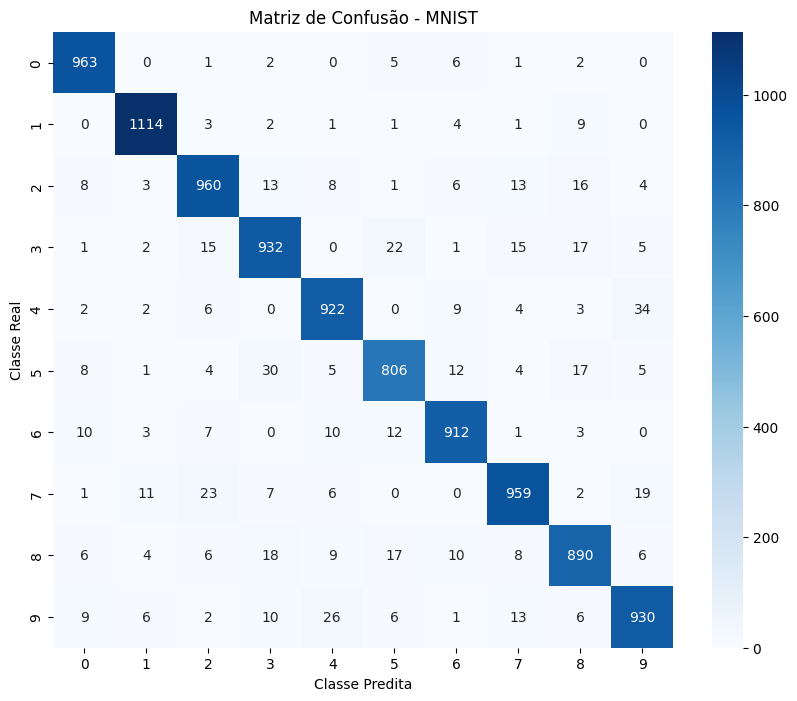

In [6]:
cm = confusion_matrix(y_test_int, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nomes_classes, 
            yticklabels=nomes_classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão - MNIST')
plt.show()